In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Problem 1: Can

$V = \pi R^2 h; S = 2\pi R h + 2 \pi R^2; h = \frac{V}{\pi R^2}; S = \frac{2V}{R} + 2 \pi R^2$
<br>
$\frac{dS}{dh} = \frac{-2V}{R^2} + 4\pi R$
<br><br>
Answer: <br>
$R = (\frac{V}{2\pi})^{1/3} $
<br>
$h = (\frac{4V}{\pi})^{1/3}$

# Problem 2

$f(x_1, x_2) = \frac{3}{2} (x^2_1 + x^2_2) + (1 + a)x_1x_2 - (x_1 + x_2) + b$ <br>
$\frac{\partial f}{\partial x_1} = 3x_1 + (1 + a) x_2 - 1$ <br>
$\frac{\partial f}{\partial x_2} = 3x_2 + (1 + a) x_1 - 1$; note that the value of $b$ doesn't matter. <br>
$\nabla f = 0$ <br>
$(9 + (1 + a)a)x_2 = 0$ unique solution $x_2 = 0$ because $9 + (1 + a) a > 0$ always. <br>
Unique optimal point $(0, 0)$ <br>
$\frac{\partial ^2 f}{\partial x_1^2} = \frac{\partial ^2 f}{\partial x_2^2} = 3$
$\frac{\partial ^2 f}{\partial x_1 \partial x_2} = 1 + a$ <br>
$\det H = 9 - (1 + a)^2$ should be $> 0$ for minimum. <br>
This holds for $a \in (-4, 2)$. <br> <br>
Answer: $a \in (-4, 2), b \in \mathbb{R}$

# Problem 3: Nelder-Mead

### Define the Mishra's Bird function

In [179]:
# constrains are imposed by returning a very big value if the argument is out of the constrain area

def my_bird(x):
    if (x[0] + 5) ** 2 + (x[1] + 5) ** 2 < 25:
        return sin(x[1]) * exp((1 - cos(x[0])) ** 2) + cos(x[0]) * exp((1 - sin(x[1])) ** 2) + (x[0] - x[1]) ** 2
    else:
        return 100000000

bird = np.vectorize(my_bird, signature='(2)->()')

In [182]:
# unconstrained version for the purpose of plotting

def my_bird_unconstrained(x):
    return sin(x[1]) * exp((1 - cos(x[0])) ** 2) + cos(x[0]) * exp((1 - sin(x[1])) ** 2) + (x[0] - x[1]) ** 2

bird_unconstrained = np.vectorize(my_bird_unconstrained, signature='(2)->()')

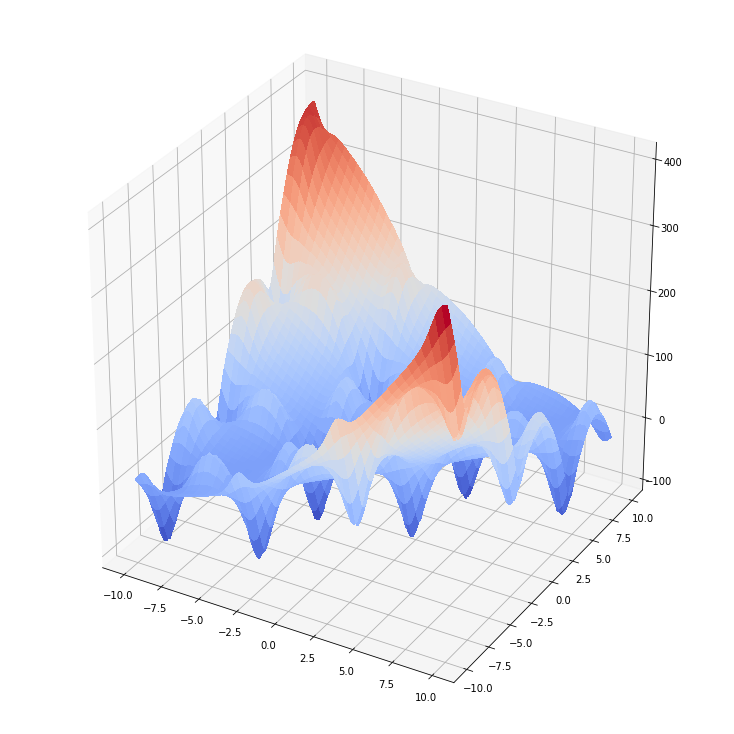

In [213]:
X = np.arange(-10, 10, 0.1)
Y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(X, Y)

Z = bird_unconstrained(np.stack((X, Y), axis=-1))

from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

### Utility Simplex class

In [195]:
class Simplex:
    def __init__(self, a, b, c):
        self.best = a
        self.worst = b
        self.middle = c
        self.reflected = None
        self.rearrange()
    
    def rearrange(self):
        vertices = np.array([self.best, self.middle, self.worst])
        vals = bird(vertices)
        indices = vals.argsort()
        vertices = vertices[indices]
        self.best = vertices[0]
        self.worst = vertices[2]
        self.middle = vertices[1]
        self.center = (self.best + self.middle) / 2
    
    def reflect(self, alpha):
        xr = self.center + alpha * (self.center - self.worst)
        self.reflected = xr
        
        return xr, bird(xr)
    
    def expand(self, gamma):
        xe = self.center + gamma * (self.reflected - self.center)
        
        return xe, bird(xe)
        
    def contract(self, rho):
        xc = self.center + rho * (self.worst - self.center)
        
        return xc, bird(xc)
    
    def shrink(self, sigma):
        self.worst = self.best + sigma *(self.worst - self.best)
        self.middle = self.best + sigma * (self.middle - self.best)
        
    def check_std(self):
        vertices = np.array([self.best, self.middle, self.worst])
        vals = bird(vertices)
        
        return np.std(vals)

### Implemeting the Nelder-Mead algorithm

In [318]:
def nelder_mead(a, b, c, alpha=1, gamma=2, rho=0.5, sigma=0.5, tol=1e-6):
    s = Simplex(a, b, c)
    triangles_to_plot = []
    oracle_calls = 0
    while True:
        triangles_to_plot.append([s.best, s.worst, s.middle])
        s.rearrange()
        bval = bird(s.best)
        mval = bird(s.middle)
        wval = bird(s.worst)
        oracle_calls += 3
        
        if s.check_std() <= tol:    # terminating if the function values don't differ too much
            return bval, s.best, np.array(triangles_to_plot), oracle_calls
        
        xr, xrval = s.reflect(alpha)
        oracle_calls += 1
        if bval <= xrval and xrval < mval:
            s.worst = xr
        elif bval > xrval:
            xe, xeval = s.expand(gamma)
            oracle_calls += 1
            if xeval < xrval:
                s.worst = xe
            else:
                s.worst = xr
        else:
            xc, xcval = s.contract(rho)
            oracle_calls += 1
            if xcval < wval:
                s.worst = xc
            else:
                s.shrink(sigma)

### Checking if it works

In [193]:
bird([-3.1302468, -1.5821422])    # global minimum from Wikipedia

array(-106.76453675)

In [196]:
minval, xstar, triangles, _ = nelder_mead([-2, -2], [-3, -3], [-1, -3], tol=1e-6)
minval, xstar

(array(-106.76453629), array([-3.13023709, -1.58219896]))

Yep, it works.

### Plotting the simplices

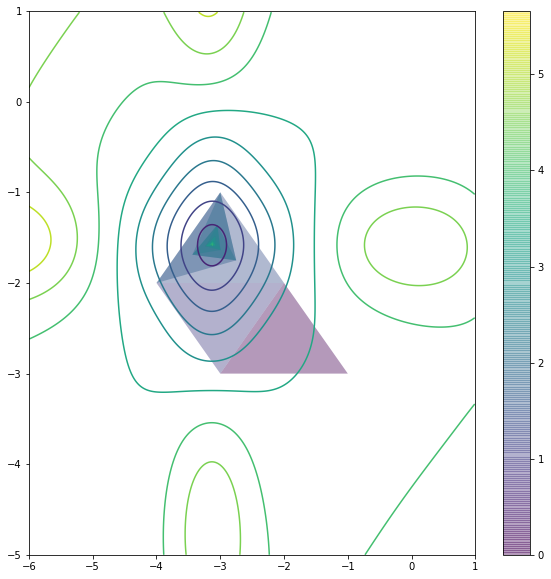

In [218]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(10, 10))

patches = []
for triangle in triangles:
    patches.append(Polygon(triangle, True))
xmin, xmax = np.min(triangles[:, :, 0]) - 2, np.max(triangles[:, :, 0]) + 2
ymin, ymax = np.min(triangles[:, :, 1]) - 2, np.max(triangles[:, :, 1]) + 2
X = np.arange(xmin, xmax, 0.01)
Y = np.arange(ymin, ymax, 0.01)
X, Y = np.meshgrid(X, Y)
Z = bird_unconstrained(np.stack((X, Y), axis=-1))
plt.contour(X, Y, Z, 10)
colors = np.sqrt(np.arange(len(patches)))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))



fig.colorbar(p, ax=ax)
plt.show()

### Convergence to a different minimum

In [271]:
# initial guess
minval, xstar, triangles1, _  = nelder_mead([-2, -0.1], [-3, -1], [-3, -0.5], tol=1e-6)
minval, xstar

(array(-106.76453556), array([-3.13015411, -1.58215083]))

In [272]:
# different starting point
minval, xstar, triangles2, _  = nelder_mead([-4, -8], [-5, -9], [-2.5, -9], tol=1e-6) 
minval, xstar

(array(-87.31088043), array([-3.17580201, -7.81995402]))

Yep, different minimum.

In [280]:
# different parameters
minval, xstar, triangles3, _  = nelder_mead([-2, -0.1], [-3, -1], [-3, -0.5], alpha=7, gamma=15, rho=0.5, sigma=0.4, tol=1e-6)
minval, xstar

(array(-92.43532033), array([-2.94195206, -1.30314678]))

Yep, different convergence point.

### Let's plot the results!
#### The last try overlaps with the initial one, so the picture is a bit messy there

In [274]:
triangles = np.vstack((triangles1, triangles2, triangles3))

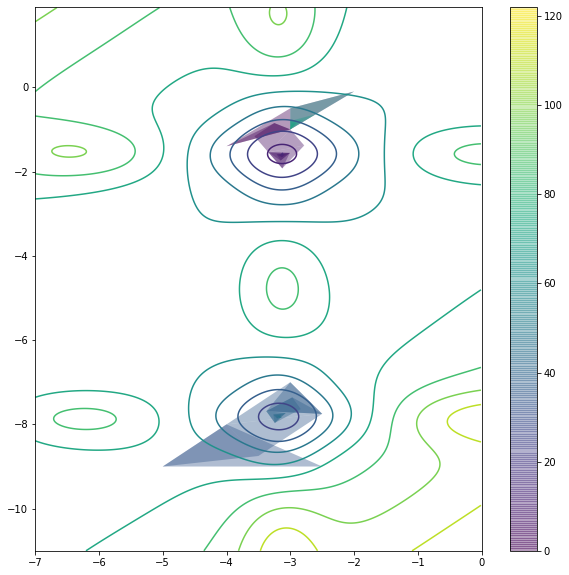

In [276]:
fig, ax = plt.subplots(figsize=(10, 10))

patches = []
for triangle in triangles:
    patches.append(Polygon(triangle, True))
xmin, xmax = np.min(triangles[:, :, 0]) - 2, np.max(triangles[:, :, 0]) + 2
ymin, ymax = np.min(triangles[:, :, 1]) - 2, np.max(triangles[:, :, 1]) + 2
X = np.arange(xmin, xmax, 0.01)
Y = np.arange(ymin, ymax, 0.01)
X, Y = np.meshgrid(X, Y)
Z = bird_unconstrained(np.stack((X, Y), axis=-1))
plt.contour(X, Y, Z, 10)
colors = np.arange(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))



fig.colorbar(p, ax=ax)
plt.show()

# Problem 4: Coordinate descent


In [310]:
def bird_x_der(x):
    return 2 * (x[0] - x[1]) - sin(x[0]) * exp((1 - sin(x[1])) ** 2) + \
            2 * sin(x[0]) * exp((1 - cos(x[0])) ** 2) * (1 - cos(x[0])) * sin(x[1])

def bird_y_der(x):
    return -2 * (x[0] - x[1]) + exp((1 - cos(x[0])) ** 2) * cos(x[1]) - \
            2 * cos(x[0]) * exp((1 - sin(x[1])) ** 2) * (1 - sin(x[1])) * cos(x[1])

In [315]:
def coordinate_descent(x0, alpha=0.001, tol=1e-6):
    prev = 100000
    cur = bird(x0)
    x_cur = x0
    oracle_calls = 1
    while np.abs(cur - prev) > tol:
        prev = cur
        x_cur[0] -= alpha * bird_x_der(x_cur)
        x_cur[1] -= alpha * bird_y_der(x_cur)
        oracle_calls += 2
        cur = bird(x_cur)

    return cur, x_cur, oracle_calls

In [316]:
minval, xstar, _ = coordinate_descent([-3, -3])
minval, xstar

(array(-106.76453616), [-3.1302489744364124, -1.5822074885985384])

Yep, works fine too.

### Let's compare the number of oracle calls

In [319]:
minval, xstar, triangles1, ncalls  = nelder_mead([-2, -0.1], [-3, -1], [-3, -0.5], tol=1e-6)
minval, xstar, ncalls

(array(-106.76453556), array([-3.13015411, -1.58215083]), 158)

In [320]:
minval, xstar, ncalls = coordinate_descent([-3, -3])
minval, xstar, ncalls

(array(-106.76453616), [-3.1302489744364124, -1.5822074885985384], 85)

Conclusion: coordinate descent and Nelder-Mead both work good, but coordinate descent needs less oracle calls.